# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import itertools

# magic word for producing visualizations in notebook
%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

In [6]:
model = xgb.XGBRegressor()

NameError: name 'xgb' is not defined

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
types_dict = {'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object}
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=types_dict)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=types_dict)

In [5]:
print('azdias data shape: ', azdias.shape)
print('customers data shape: ', customers.shape)

azdias data shape:  (891221, 366)
customers data shape:  (191652, 369)


In [7]:
azdias.iloc[:,18] = pd.to_numeric(azdias.iloc[:,18], errors='coerce')
azdias.iloc[:,19] = pd.to_numeric(azdias.iloc[:,19], errors='coerce')
customers.iloc[:,18] = pd.to_numeric(customers.iloc[:,18], errors='coerce')
customers.iloc[:,19] = pd.to_numeric(customers.iloc[:,19], errors='coerce')
print(azdias.dtypes[18:20])
print(customers.dtypes[18:20])

CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object
CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object


#### Explore azdias data

In [12]:
# Check NaN values
perc_nan = azdias.isnull().mean()
print('Column No. with >50% NaN: ', np.where(perc_nan>0.5))

Column No. with >50% NaN:  (array([  4,   5,   6,   7, 100, 300]),)


In [15]:
azdias.iloc[:,[4,   5,   6,   7, 100, 300]].head()

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,EXTSEL992,KK_KUNDENTYP
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,14.0,NaN
3,NaN,NaN,NaN,NaN,31.0,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0


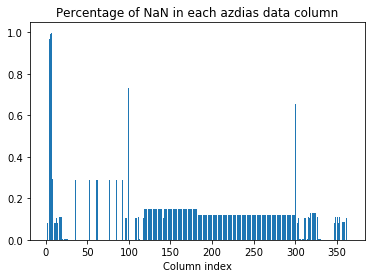

In [13]:
plt.bar(np.arange(len(perc_nan)), perc_nan);
plt.title('Percentage of NaN in each azdias data column');
plt.xlabel('Column index');

In [18]:
azdias.EXTSEL992.describe()

count    237068.000000
mean         33.338392
std          14.537408
min           1.000000
25%          23.000000
50%          34.000000
75%          43.000000
max          56.000000
Name: EXTSEL992, dtype: float64

In [24]:
num_azd = azdias.select_dtypes(include=['int','float64']).columns
bool_azd = azdias.select_dtypes(include=['bool']).columns
cat_azd = azdias.select_dtypes(include=['object']).columns
len(num_azd), len(bool_azd), len(cat_azd)

(362, 0, 4)

In [33]:
azdias.loc[:,cat_azd].head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W


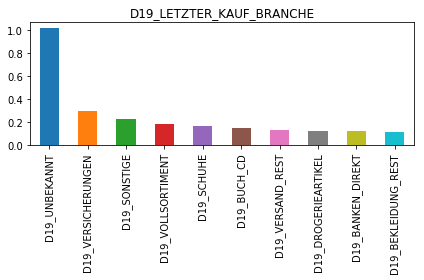

In [36]:
count_vals = azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()
(count_vals[:10]/customers.shape[0]).plot(kind='bar');
plt.title('D19_LETZTER_KAUF_BRANCHE');
plt.tight_layout();

In [5]:
num_azd.iloc[1].max()

910220.0

In [6]:
range_num_azd = num_azd.max() - num_azd.min()

In [8]:
sum(range_num_azd==0)

0

#### Explore customers data

In [21]:
# Check NaN values
perc_na = customers.isnull().mean()
print('Column No. with >50% NaN: ', np.where(perc_na>0.5))

Column No. with >50% NaN:  (array([  4,   5,   6,   7, 300]),)


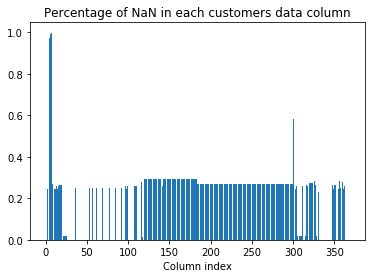

In [35]:
plt.bar(np.arange(len(perc_na)), perc_na);
plt.title('Percentage of NaN in each customers data column');
plt.xlabel('Column index');

In [19]:
customers.EXTSEL992.describe()

count    106369.000000
mean         38.418599
std          13.689466
min           1.000000
25%          29.000000
50%          36.000000
75%          53.000000
max          56.000000
Name: EXTSEL992, dtype: float64

In [20]:
customers.KK_KUNDENTYP.describe()

count    79715.000000
mean         3.421803
std          1.623890
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: KK_KUNDENTYP, dtype: float64

In [9]:
num_cust = customers.select_dtypes(include=['int','float64'])
bool_cust = customers.select_dtypes(include=['bool'])
cat_cust = customers.select_dtypes(include=['object'])
num_cust.shape, bool_cust.shape, cat_cust.shape

((191652, 361), (191652, 0), (191652, 8))

In [10]:
range_num_cust = num_cust.max() - num_cust.min()

In [11]:
sum(range_num_cust==0)

0

In [27]:
cat_cust.columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [38]:
np.setdiff1d(np.array(num_cust.columns), np.intersect1d(np.array(num_cust.columns), np.array(num_azd.columns)))

array(['ONLINE_PURCHASE'], dtype=object)

In [40]:
customers['ONLINE_PURCHASE'].describe()

count    191652.000000
mean          0.090247
std           0.286536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ONLINE_PURCHASE, dtype: float64

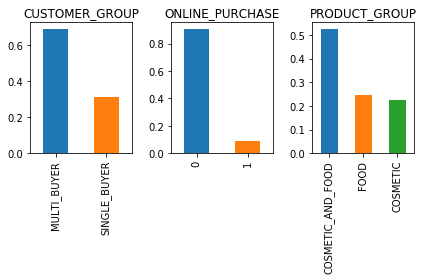

In [23]:
col_names = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
i=1
for col_name in col_names:
    plt.subplot(1,3,i)
    count_vals = customers[col_name].value_counts()

    (count_vals[:10]/customers.shape[0]).plot(kind='bar');
    plt.title(col_name);
    plt.tight_layout();
    i +=1

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Define function to load and clean data

In [4]:
def load_and_clean_data(file_name):
    '''
    INPUT
    file_name - csv file name
    
    OUTPUT 
    df - pandas dataframe 
    
    This function load data from csv file to df and cleans df by the following steps:
    1. Convert 2 columns from string to number
    2. Drop 4 columns with 90% more NaNs and 1 datetime column
    3. Fill NaNs in numeric columns with label of unknown
    4. Encode category columns to numeric columns
    
    '''
    # Load data from csv file
    types_dict = {'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object}
    df = pd.read_csv(file_name, sep=';', dtype=types_dict)
    print('File loaded...')
    print('data shape before cleaning: {}'.format(df.shape))
    
    # Convert two columns to numeric type
    df.CAMEO_DEUG_2015 = pd.to_numeric(df.CAMEO_DEUG_2015, errors='coerce')
    df.CAMEO_INTL_2015 = pd.to_numeric(df.CAMEO_INTL_2015, errors='coerce')

    # Drop columns with more than 90% of missing values and some less relevant category columns
    df = df.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EINGEFUEGT_AM'], axis=1)
    
    # Map NaN to Unknown label 10 in the following columns
    col_unknown_10 = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                       'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM', 
                       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'];
    for col in col_unknown_10:
        df[col].fillna(10, inplace=True) 
 
    # Map NaN and -1 to Unknown label 0 in the following columns
    col_name0 = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','GEBAEUDETYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX',
                 'KBA05_GBZ','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ',
                 'WOHNDAUER_2008','W_KEIT_KIND_HH','KKK']
    for col in col_name0:
        df[df[col]==-1] = 0
        df[col].fillna(0, inplace=True)
    
    # Map NaN and -1 to Unknown label 9 in the following columns
    indx00 = np.where(df.columns.str.match('KBA05_CCM1'))[0][0]
    indx01 = np.where(df.columns.str.match('KBA05_FRAU'))[0][0]+1                  
    indx10 = np.where(df.columns.str.match('KBA05_HERST1'))[0][0]
    indx11 = np.where(df.columns.str.match('KBA05_ZUL4'))[0][0]+1                                 
    indx20 = np.where(df.columns.str.match('SEMIO_DOM'))[0][0]
    indx21 = np.where(df.columns.str.match('SEMIO_VERT'))[0][0]+1
                  
    indx3 = np.where(df.columns.str.match('D19_KONSUMTYP'))[0][0]                 
    indx4 = np.where(df.columns.str.match('RELAT_AB'))[0][0]
    indx5 = np.where(df.columns.str.match('ZABEOTYP'))[0][0]
                 
    col_indx = np.concatenate((np.arange(indx00,indx01),np.arange(indx10,indx11),np.arange(indx20,indx21),
                               np.arange(indx3,indx3+1),np.arange(indx4,indx4+1),np.arange(indx5,indx5+1)))
    col_name9 = df.columns[col_indx]
    for col in col_name9:
        df[df[col]==-1] = 9
        df[col].fillna(9, inplace=True)
    
    # Replace NaN in the rest of numeric columns with min()
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].min()), inplace=True)  
    print('NaN in numeric columns filled...')
          
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        
    print('File cleaned.')
    print('data shape after cleaning: {}'.format(df.shape))
    
    return df

### 1.1 Run clustering for azdias data

**Load and clean "azdias" data**

In [3]:
azdias_clean = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv')

File loaded...
5 columns are dropped...
NaN in numeric columns filled...
Rows with NaN droppped...
File cleaned.


In [6]:
azdias_clean.shape

(615341, 437)

**Perform PCA to reduce features before clustering**

In [5]:
# Standardize data for PCA
azdias_std = StandardScaler().fit_transform(azdias_clean)
print('Standardized data...')
# Perform PCA
pca = PCA().fit(azdias_std)
print('PCA is done.')

Standardized data...


**Choose minimum number of features to perserve 90% of data characterization**

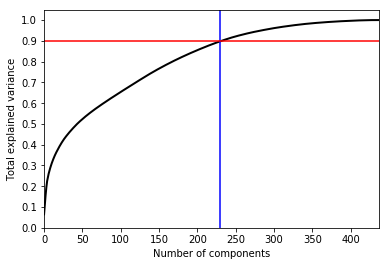

In [15]:
# Plot PCA results
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 437)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(230, c='b')
plt.axhline(0.9, c='r')
plt.show();

#### Get transformed azdias data with 230 principal features

In [6]:
# Perform PCA with 230 features
pca90 = PCA(n_components=230)
principalComponents = pca90.fit_transform(azdias_std) 
azdias_principal= pd.DataFrame(data = principalComponents)
# finalDf = pd.concat([principalDf, finalDf[['species']]], axis = 1) 

In [16]:
azdias_principal.shape

(615341, 230)

**Choose a reasonable cluser number**

Run k-means to cluster the neighborhood into 2~20 clusters. Calculate the sum of squared distance to find the optimal cluster number.

In [3]:
def choose_kmean_number(df):
    '''
    INPUT 
    df - pandas dataframe 
    
    OUTPUT
    None
    
    This function display elbow plot for k-mean clustering on df
    
    '''
    Sum_of_squared_distances = []
    for k in range(2,20,2):
        # run k-means clustering
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        # Record sum of squared distances of samples to the nearest cluster center
        Sum_of_squared_distances.append(kmeans.inertia_)

    K = range(2,20,2)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k',fontsize=14)
    plt.ylabel('Sum_of_squared_distances',fontsize=14)
    plt.title('Elbow method for optimal k',fontsize=14)
    plt.show()

In [ ]:
choose_kmean_number(azdias_principal)

#### Run k-means clusering for 10 clusters

In [5]:
def kmean_clustering(k, df_pca, df):
    '''
    INPUT 
    k - number of clustering
    df_pca - pandas dataframe with reduced features after PCA
    df - original pandas dataframe 
    
    OUTPUT
    df - original pandas dataframe with cluster label added to the first column
    
    This function groups df_pca into k clusters and add cluster labels to the original df
    
    '''
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_pca)

    # add clustering labels to df
    df.insert(0, 'Cluster Label', kmeans.labels_)

    return df

Let's add the cluster label to dataframe

In [17]:
azdias = kmean_clustering(kclusters=10, azdias_principal, azdias)
azdias.head()

,Cluster Label,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
2,9,910225,-1,9.0,17.0,17.000000,10.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,1
3,5,910226,2,1.0,13.0,13.000000,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
4,0,910241,-1,1.0,20.0,14.000000,3.0,0.0,0.0,4.0,...,0,0,0,0,0,0,0,0,0,1
5,5,910244,3,1.0,10.0,10.000000,5.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
6,9,910248,-1,9.0,0.0,13.700717,4.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,1


#### Check each cluster

In [20]:
azdias.groupby('Cluster Label').LNR.count()

Cluster Label
0     55977
1     59325
2    100207
3     54451
4     43019
5     97662
6      7170
7     75080
8     40034
9     82416
Name: LNR, dtype: int64

### 1.2 Run clustering for customers data

#### Load and clean "customers" data

In [24]:
customers_clean = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv')

File loaded...
5 columns are dropped...
NaN in numeric columns filled...
Rows with NaN droppped...
File cleaned.


In [26]:
customers_clean.shape

(140168, 441)

#### Perform PCA to reduce features before clustering

In [119]:
def choose_principal_components(df, percent):
    '''
    INPUT 
    df - pandas dataframe 
    percent - percentage of data variance to be perserved after pca
    
    OUTPUT
    df_principal - ordered principal components of df
    num_pca - minimum number of principal components that perserves more than "percent" of variance of df
    pca - PCA model
    
    This function perform PCA on df and return pca model and principal components in order
    and plot accumulated percentage of variance explained by each of the principal components.
    
    '''
    # Standardize data for PCA
    df_std = StandardScaler().fit_transform(df)
    print('Standardized data...')
    
    # Perform PCA
    pca = PCA(n_components=df.shape[1]) 
    principal_components = pca.fit_transform(df_std) 
    df_principal= pd.DataFrame(data = principal_components)
    print('PCA is done.')
    
    # Accumulate percentage of variance explained by each of the principal components.
    perc_pca = np.cumsum(pca.explained_variance_ratio_)
    # Minimum number of principal components that perserves more than 90% of variance of df
    num_pca = np.where(perc_pca>=percent)[0][0]
    print('Keep {} features.'.format(num_pca))
    
    # Plot PCA results
    plt.figure(figsize=(6,4))
    plt.plot(perc_pca, color='k', lw=2)
    plt.xlabel('Number of components')
    plt.ylabel('Total explained variance')
    plt.xlim(0, df.shape[1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axvline(num_pca, c='b')
    plt.axhline(0.9, c='r')
    plt.show();
    
    return df_principal.iloc[:,0:num_pca], num_pca, pca(n_components=num_pca)

#### Choose minimum number of features to perserve 90% of data characterization

In [ ]:
customers_principal, num_pca, pca = choose_principal_components(customers_clean)

#### Choose a reasonable cluser number

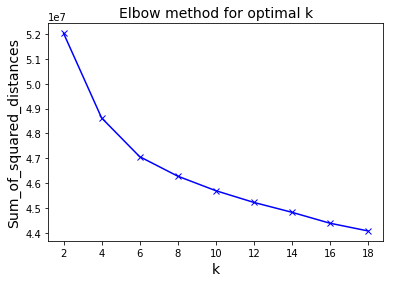

In [33]:
choose_kmean_number(customers_principal)

In [34]:
# customers = kmean_clustering(kclusters=10, customers_principal, customers)
customers = kmeans.predict(customers_principal)
# add clustering labels to dataframe
customers.insert(0, 'Cluster Label', kmeans.labels_)
customers.head()

,Cluster Label,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_SINGLE_BUYER
0,9,9626,2,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,...,0,1,0,0,0,0,1,1,0,0
2,9,143872,-1,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,...,0,1,0,0,0,0,1,1,0,0
3,2,143873,1,1.0,8.0,8.0,0.0,0.067413,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,6,143874,-1,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,...,0,0,0,0,0,0,1,0,1,0
5,7,143888,1,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,...,0,0,0,0,0,0,1,1,0,0


In [35]:
customers.groupby('Cluster Label').LNR.count()

Cluster Label
0    13567
1    22368
2    19954
3     7026
4    15643
5      876
6    12571
7    13441
8    10655
9    24067
Name: LNR, dtype: int64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv')

File loaded...
data shape before cleaning: (42962, 367)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (42962, 438)


In [7]:
X_train = mailout_train.drop('RESPONSE',axis=1)
Y_train = mailout_train['RESPONSE']

In [8]:
def choose_principal_components(df, percent=0.9):
    '''
    INPUT 
    df - pandas dataframe 
    percent - percentage of data variance to be perserved after pca
    
    OUTPUT
    df_principal - ordered principal components of df
    weight_pca - percentage of variance explained by each of the principal components.
    num_pca - minimum number of principal components that perserves more than "percent" of variance of df
    
    This function perform PCA on df and return pca model and principal components in order
    and plot accumulated percentage of variance explained by each of the principal components.
    
    '''
    # Standardize data for PCA
    df_std = StandardScaler().fit_transform(df)
    print('Standardized data...')
    
    # Perform PCA
    pca = PCA(n_components=df.shape[1]) 
    pca.fit(df_std) 
    print('Initial PCA is done...')
    
    # Accumulate percentage of variance explained by each of the principal components.
    weight_pca = pca.explained_variance_ratio_
    perc_pca = np.cumsum(weight_pca)
    # Minimum number of principal components that perserves more than 90% of variance of df
    num_pca = np.where(perc_pca>=percent)[0][0]
    
    # PCA transform df_std to num_pca components
    pca = PCA(n_components=num_pca) 
    principal_components = pca.fit_transform(df_std) 
    df_principal= pd.DataFrame(principal_components)
    print('Final PCA keeps {} features.'.format(num_pca))
    
    # Plot PCA results
    plt.figure(figsize=(6,4))
    plt.plot(perc_pca, color='k', lw=2)
    plt.xlabel('Number of components')
    plt.ylabel('Total explained variance')
    plt.xlim(0, df.shape[1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axvline(num_pca, c='b')
    plt.axhline(percent, c='r')
    plt.show();
    
    return df_principal, num_pca, pca

Standardized data...
Initial PCA is done...
Final PCA keeps 185 features.


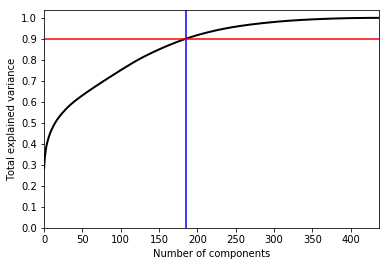

In [9]:
X_train_pca, num_pca, pca = choose_principal_components(X_train, 0.9)

In [71]:
def down_sample_class0(X_train_pca, Y_train, k_cluster=10, DnSamp_rate=20):
    '''
    INPUT
    X_train_pca - 2D dataframe for down-sampling
    Y_train - 1D array which contains class label 0/1 with the same index as X_train_pca
    k_cluster - k-mean cluster number 
    DnSamp_rate - down-sampling rate
    
    OUTPUT
    X_train_pca_DnSamp - 2D dataframe for down-sampled X_train_pca
    Y_train_DnSample - 1D array of class labels 0/1 
    
    This function performs k-mean clustering on X_train_pca, and down sample class 0 data in each cluster
    
    '''
    # Run k_mean cluster for 10 cluster on class 0 of traning data
    X_train_pca_class0 = X_train_pca[Y_train==0]
    X_train_pca_class1= X_train_pca[Y_train==1]
    print('Original Class1/Class0 = {}'.format(sum(Y_train==1)/sum(Y_train==0)))

    X_train_pca_class0_cluster = kmean_clustering(k_cluster, X_train_pca_class0, X_train_pca_class0)
    print('K-mean clustering is done for {} clusters.'.format(k_cluster))

    # Down-sample in each cluster of class 0 
    cluster_size = X_train_pca_class0_cluster.groupby('Cluster Label').count()[0]
    X_train_pca_DnSamp = pd.DataFrame()
    for i in np.arange(k_cluster):
        df_cluster = X_train_pca_class0_cluster[X_train_pca_class0_cluster['Cluster Label']==i]
        X_train_pca_DnSamp = X_train_pca_DnSamp.append(df_cluster.sample(n=round(cluster_size[i]/DnSamp_rate).astype(int), 
                                                          random_state=i))

    # Append class 1 data
    X_train_pca_DnSamp.drop('Cluster Label',axis=1,inplace=True)
    num_class0 = X_train_pca_DnSamp.shape[0]
    X_train_pca_DnSamp = X_train_pca_DnSamp.append(X_train_pca_class1)
    print('Down sampled total X_train_pca size: {}'.format(X_train_pca_DnSamp.shape))

    # Down sample Y_train
    Y_train_DnSample = np.zeros(X_train_pca_DnSamp.shape[0], dtype=int)
    Y_train_DnSample[num_class0:] = 1
    print('Down sampled Class1/Class0 = {}'.format(sum(Y_train_DnSample==1)/sum(Y_train_DnSample==0)))

    return X_train_pca_DnSamp, Y_train_DnSample

In [72]:
X_train_pca_DnSamp, Y_train_DnSample = down_sample_class0(X_train_pca, Y_train, k_cluster=10, DnSamp_rate=50)

Original Class1/Class0 = 0.012538298373792129
K-mean clustering is done for 10 clusters.
Down sampled total X_train_pca size: (1380, 185)
Down sampled Class1/Class0 = 0.6273584905660378


In [73]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train_pca_DnSamp, Y_train_DnSample)
yhat = clf.predict(X_train_pca)
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
clf

ROC score: 0.6481902523218251


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [74]:
print('Training   class1: {}, class0: {}, class1/class0: {}'.
      format(sum(Y_train==1),sum(Y_train==0),round(sum(Y_train==1)/sum(Y_train==0),2)))
print('Prediction class1: {}, class0: {}, class1/class0: {}'.
      format(sum(yhat==1),sum(yhat==0),round(sum(yhat==1)/sum(yhat==0),2)))
score_train = clf.score(X_train_pca, Y_train)
score_train

Training   class1: 532, class0: 42430, class1/class0: 0.01
Prediction class1: 11409, class0: 31553, class1/class0: 0.36


0.73588287323681389

In [75]:
# Build pipeline
pipeline = Pipeline([
                ('clf', LogisticRegression(verbose=0, random_state=42))
                ])
pipeline

Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [76]:
# LR = LogisticRegression(C=0.02, solver='sag').fit(X_train_pca_DnSamp, Y_train_DnSample)
pipeline.fit(X_train_pca_DnSamp, Y_train_DnSample)
yhat = pipeline.predict(X_train_pca)
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))

ROC score: 0.6492115275225536


In [87]:
# Use GridSearchCV to optimize model
parameters = {
    'clf__C': [0.01, 0.1, 1]
}

cv = GridSearchCV(pipeline, param_grid=parameters,scoring='roc_auc',cv=3)
cv

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [88]:
cv.fit(X_train_pca_DnSamp, Y_train_DnSample)
print("\nBest Parameters:", cv.best_params_)


Best Parameters: {'clf__C': 1}


In [89]:
yhat = pipeline.predict(X_train_pca)
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
yhat_prob = cv.predict_proba(X_train_pca)
yhat_prob[0:2]

ROC score: 0.6492115275225536


array([[ 0.23,  0.77],
       [ 0.92,  0.08]])

In [90]:
print('Training   class1: {}, class0: {}, class1/class0: {}'.
      format(sum(Y_train==1),sum(Y_train==0),round(sum(Y_train==1)/sum(Y_train==0),2)))
print('Prediction class1: {}, class0: {}, class1/class0: {}'.
      format(sum(yhat==1),sum(yhat==0),round(sum(yhat==1)/sum(yhat==0),2)))
score_train = cv.score(X_train_pca, Y_train)
score_train

Training   class1: 532, class0: 42430, class1/class0: 0.01
Prediction class1: 10111, class0: 32851, class1/class0: 0.31


0.72622802882766657

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    INPUT
    cm - actual class in 1D array
    classes - predicted class in 1D array
    
    OUTPUT
    None
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  282   250]
 [ 9829 32601]]


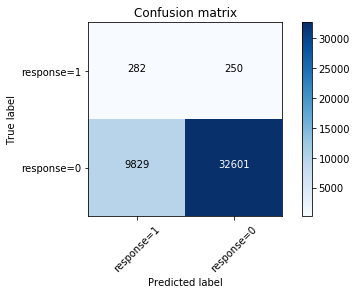

In [91]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_train, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','response=0'],normalize= False,  title='Confusion matrix')

In [153]:
print (classification_report(Y_train, yhat))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98     42430
          1       0.05      0.14      0.07       532

avg / total       0.98      0.96      0.97     42962



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [110]:
# Load and clean test data
mailout_test = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv')

File loaded...
data shape before cleaning: (42833, 366)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (42833, 437)


In [124]:
# Perform PCA on test data as same as PCA on training data
X_test_pca = pca.transform(mailout_test)

In [129]:
# Predict on test data
y_test_est = clf.predict(X_test_pca)
# Save predic results to dataframe
df_predict = pd.DataFrame(mailout_test['LNR'])
df_predict['RESPONSE'] = y_test_est

In [130]:
df_predict['RESPONSE'].mean()

0.050801951766161604

In [131]:
df_predict.to_csv('predict_test.csv', index=False, sep=',', encoding='utf-8')